In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pathlib
import zipfile
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch.nn as nn
import pandas as pd
import seaborn as sns

In [2]:
import os

In [3]:
! conda install -y gdown
!gdown --id 1fOCHmxc1MrXc-AHnvcqYvHu0y9LupOhV
!gdown --id 1vkTHZqjYynj0-eymcFkPND4GvJvyd8BE
!unzip -u ./test.zip -d ./test 
!unzip -u ./train.zip -d ./train 

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.10.3               |   py37h89c1867_2         3.1 MB  conda-forge
    filelock-3.1.0             |     pyhd8ed1ab_1          11 KB  conda-forge
    gdown-3.14.0               |     pyhd8ed1ab_0          12 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.1.0-pyhd8ed1ab_1
  gdown              conda-forge/noarch::gdown-3.14.0-pyhd8ed1ab_0

The following packages will be UPDATED:

  conda                               4.10.3-py37h89c1867_1 --> 4.10.3-py37h89c1867_2



gdown-3.14.0         | 12 KB     | ####################

In [4]:
train='./train'
test='./test'

classes = os.listdir(test) 
print(classes)

def totalSize(path):
    sum = 0;
    for path, subdirs, files in os.walk(path):  ## walk directory    
        sum += len(files)
    return sum

print("Train Number Of Images : ",totalSize(train))
print("Test Number Of Images : ",totalSize(test))

['meningioma_tumor', 'glioma_tumor', 'pituitary_tumor', 'no_tumor']
Train Number Of Images :  2870
Test Number Of Images :  394


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


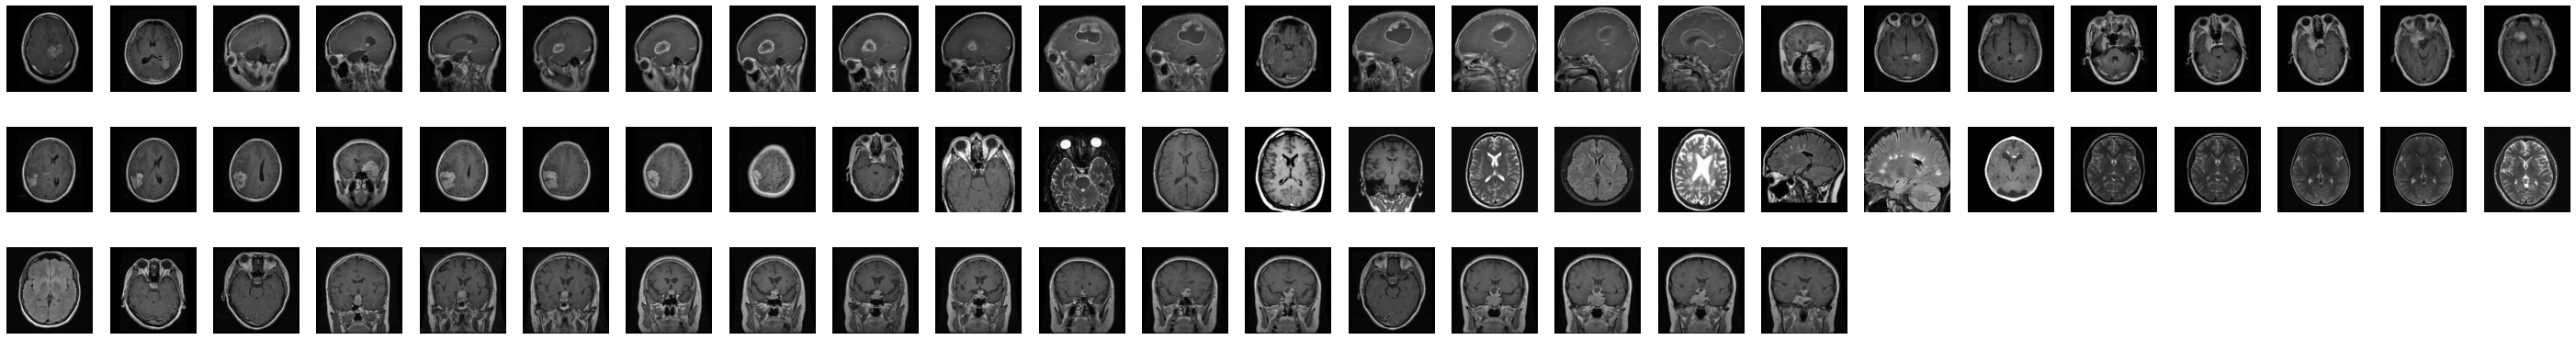

In [5]:
NUMBER_OF_IMAGE_SHOW = 17  ## how many image you want to show
preview_images_path = []

for path, subdirs, files in os.walk(train):
    subdirs.sort()
    files.sort()
    i = 0;
    for name in files:
        i +=1
        val = str( os.path.join(path, name) )
        preview_images_path.append(val)
        if(i is NUMBER_OF_IMAGE_SHOW):
            break

plt.figure(figsize=(50, 60))
for i,path in enumerate(preview_images_path):
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    plt.subplot(50/2 , 25,i+1)
    # plt.imshow(img)
    plt.axis("off")
    plt.imshow(img[...,::-1]) # RGB-> BGR
plt.show()

In [6]:

BATCH_SIZE = 16  
IMAGE_SIZE = 224 
transform = transforms.Compose([

                                # torchvision.transforms.ColorJitter(brightness=0.4),
#                                 transforms.RandomRotation(20,expand=True), 
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(),
                                transforms.CenterCrop(IMAGE_SIZE),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                
                               ])
train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train,transform=transform),
    batch_size=BATCH_SIZE, shuffle=True
)

transform2 = transforms.Compose([
                                
                                transforms.Resize(IMAGE_SIZE),  ## image resize
                                transforms.ToTensor(), ## array converted into torch tensor and then divided by 255 (1.0/255)
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                               ])

test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test,transform=transform2),
    batch_size=BATCH_SIZE, shuffle=True
)

In [63]:
import torchvision.models as models

models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [65]:
# from torch.optim.lr_scheduler import StepLR
import torchvision.models as models
resnet18= models.resnet18(pretrained=True)

# image size must be >= 299 x 299 during training if aux_logits is set to be True.

resnet18.cuda()
num_classes =4
batch_size = BATCH_SIZE

learning_rate=0.0001

optimizer = torch.optim.Adam(resnet18.parameters(),lr=learning_rate)

# scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
 
criterion = torch.nn.CrossEntropyLoss()

resnet18.fc = nn.Linear(512, 4)
resnet18.cuda()
print("Model Is Ready To Run ")

Model Is Ready To Run 


In [67]:
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [68]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [69]:
PATH='./resnet18.pth'

training_losses = []
training_accuracy = []
validation_losses = []
validation_accuracy = []
totalsteps = []
epochs = 10
steps = 0
running_loss = 0
print_every = 1

#epoch iteration
for epoch in range(epochs):
    accuracy = 0
    for inputs, labels in train_loader:
        resnet18.train()
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() # clears old gradients from the last step (otherwise you’d just accumulate the gradients from all loss.backward() calls).
        
        logps = resnet18.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward() # computes the derivative of the loss w.r.t. the parameters (or anything requiring gradients) using backpropagation
        optimizer.step() # the optimizer to take a step based on the gradients of the parameters.
 
        #Calculate traning accuracy
        pred = torch.argmax(logps, dim=1)
        correct = pred.eq(labels)
       
        running_loss += loss.item()
        accuracy += torch.mean(correct.float())
        
        if steps % print_every == 0:
            after_train_accuracy=accuracy/print_every
            validation_loss = 0
            accuracy = 0
            resnet18.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = resnet18.forward(inputs)
                    batch_loss = criterion(logps, labels)                    
                    validation_loss += batch_loss.item()
                    pred = torch.argmax(logps, dim=1)
                    correct = pred.eq(labels)
                    accuracy += torch.mean(correct.float())
            
            training_losses.append(running_loss/print_every)
            training_accuracy.append(after_train_accuracy)
            validation_losses.append(validation_loss/len(test_loader))
            validation_accuracy.append(accuracy/len(test_loader))
            totalsteps.append(steps)
            print(f"Device {device} "
                  f"Epoch {epoch+1}/{epochs} "
                  f"Step {steps} "
                  f"Train loss: {running_loss/print_every:f} "
                  f"Train accuracy: {after_train_accuracy:f} "
                  f"Validation loss: {validation_loss/len(test_loader):f} "
                  f"Validation accuracy: {accuracy/len(test_loader):f}")
            running_loss = 0
            accuracy = 0
            resnet18.train()
print('Finish Train')
torch.save(resnet18.state_dict(), PATH)

Device cuda Epoch 1/10 Step 1 Train loss: 1.468745 Train accuracy: 0.312500 Validation loss: 1.558748 Validation accuracy: 0.278500
Device cuda Epoch 1/10 Step 2 Train loss: 1.078697 Train accuracy: 0.500000 Validation loss: 1.480806 Validation accuracy: 0.297000
Device cuda Epoch 1/10 Step 3 Train loss: 1.247158 Train accuracy: 0.125000 Validation loss: 1.413018 Validation accuracy: 0.330500
Device cuda Epoch 1/10 Step 4 Train loss: 0.853066 Train accuracy: 0.812500 Validation loss: 1.361469 Validation accuracy: 0.376000
Device cuda Epoch 1/10 Step 5 Train loss: 0.998549 Train accuracy: 0.437500 Validation loss: 1.316517 Validation accuracy: 0.396500
Device cuda Epoch 1/10 Step 6 Train loss: 1.310152 Train accuracy: 0.375000 Validation loss: 1.290700 Validation accuracy: 0.409500
Device cuda Epoch 1/10 Step 7 Train loss: 0.788184 Train accuracy: 0.687500 Validation loss: 1.276749 Validation accuracy: 0.422500
Device cuda Epoch 1/10 Step 8 Train loss: 1.133101 Train accuracy: 0.562500 

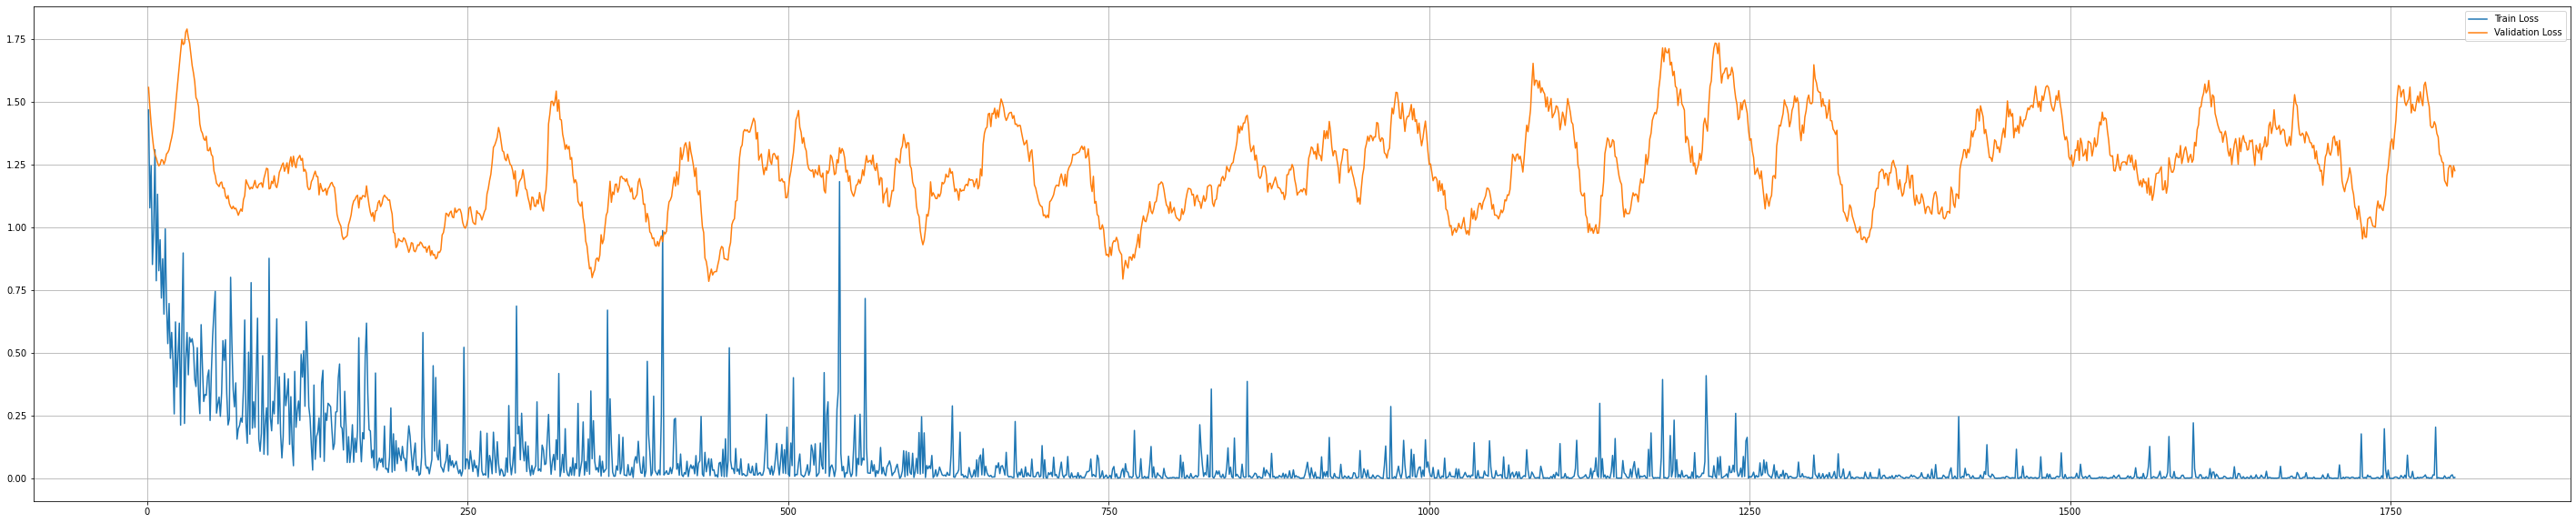

In [70]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_losses, label='Train Loss')
plt.plot(totalsteps, validation_losses, label='Validation Loss')
plt.legend()
plt.grid()
plt.show()

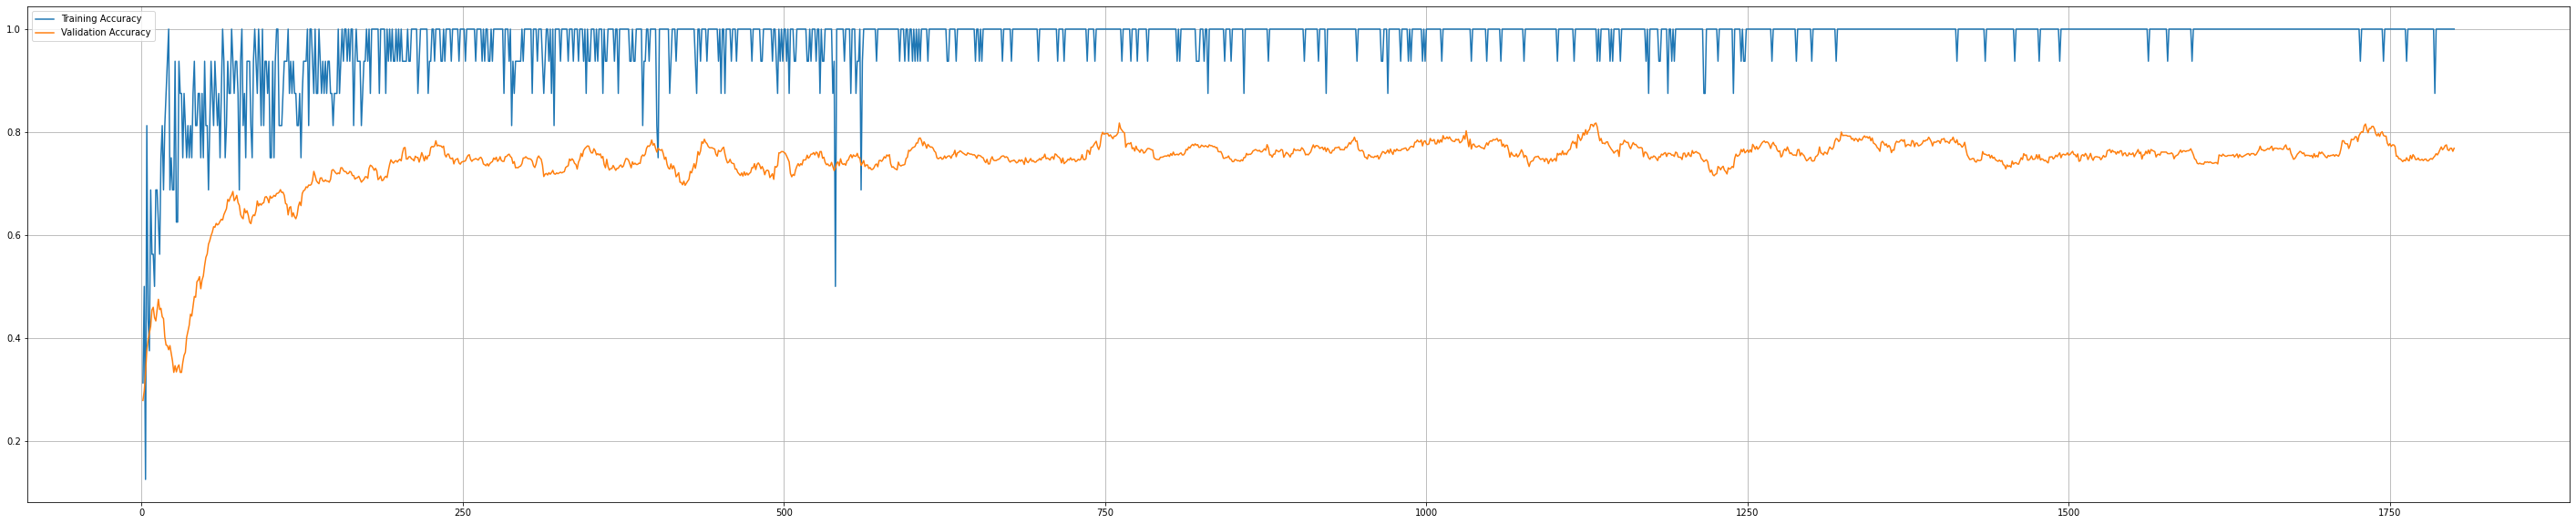

In [71]:
#display stats in graph
plt.figure(figsize=(50, 10))
plt.plot(totalsteps, training_accuracy, label='Training Accuracy')
plt.plot(totalsteps, validation_accuracy, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [72]:
total = 0
correct=0
with torch.no_grad():
    resnet18.eval()
    for inputs, labels in test_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(total)
print(correct) 

print('Accuracy of the network test images: %d %%' % (100 * correct / total))

394
302
Accuracy of the network test images: 76 %


In [73]:
y_true_tensor = torch.tensor([]).cuda()
y_pred_tensor = torch.tensor([]).cuda()
vgg19.eval()
for i,(inputs, labels) in enumerate(test_loader):

  inputs, labels = inputs.to(device), labels.to(device)
  outputs = resnet18(inputs)
  _, preds = torch.max(outputs, 1)
  y_true_tensor = torch.cat((y_true_tensor,labels))
  y_pred_tensor = torch.cat((y_pred_tensor,preds))

In [74]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [75]:
y_true = y_true_tensor.tolist()
y_pred = y_pred_tensor.tolist()

In [76]:
matrix = confusion_matrix(y_true,y_pred)
matrix

array([[ 28,  23,  49,   0],
       [  0, 114,   1,   0],
       [  0,   0, 105,   0],
       [  0,   6,  13,  55]])

In [77]:
test_set = torchvision.datasets.ImageFolder(test, transform=transform2)


In [78]:
target_names = list(test_set.class_to_idx.keys())

In [79]:
classify_report = classification_report(y_true, y_pred, target_names=target_names)
print(classify_report)

                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.28      0.44       100
meningioma_tumor       0.80      0.99      0.88       115
        no_tumor       0.62      1.00      0.77       105
 pituitary_tumor       1.00      0.74      0.85        74

        accuracy                           0.77       394
       macro avg       0.86      0.75      0.74       394
    weighted avg       0.84      0.77      0.73       394



Text(0.5, 14.09375, 'Predicted label')

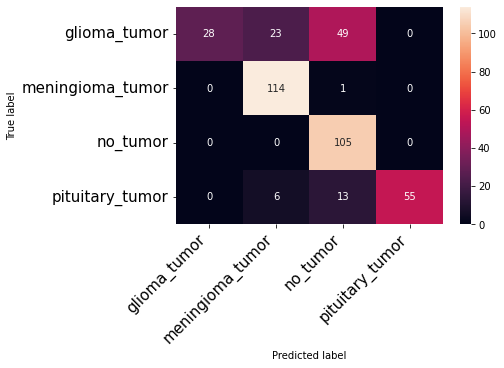

In [80]:
import pandas as pd
import seaborn as sns
df_cm = pd.DataFrame(matrix, index=target_names, columns=target_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [81]:
# def test_class_probabilities(googlenet, device, test_loader, which_class):
#     googlenet.eval()
#     actuals = []
#     probabilities = []
#     with torch.no_grad():
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             output = googlenet(data)
#             prediction = output.argmax(dim=1, keepdim=True)
#             actuals.extend(target.view_as(prediction) == which_class)
#             probabilities.extend(np.exp(output[:, which_class]))
#     return [i.item() for i in actuals], [i.item() for i in probabilities]

# which_class = 4
# actuals, class_probabilities = test_class_probabilities(model, device, test_loader, which_class)

# fpr, tpr, _ = roc_curve(actuals, class_probabilities)
# roc_auc = auc(fpr, tpr)
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC for digit=%d class' % which_class)
# plt.legend(loc="lower right")
# plt.show()
